In [91]:
from IPython.core.display import HTML

# source https://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code" align="center" " ></form>
''')

[An online version of this notebook is available here](https://nbviewer.jupyter.org/github/lorenzodenisi/Heart-Failure-Clinical-Records/blob/master/Heart%20Failures.ipynb) <br>

# Heart Failure clinical records <img src="img/heart.png" width="120" height="120" align="right"/>

Heart failure occurs when the heart is not able to pump enough blood to the body.<br>
HF are only a subgroup of all the **cardiovascular diseases** that comprehend also coronary heart diseases (heart attacks), cerebrovascular diseases (strokes) and other pathologies that altogether kill every year  approximately **17 million people** around the world.<br>



Machine learning applied to medical records can be useful to  predict the survival of a patient, highlighting patterns and even ranking the features to understand which are **risk factors**, possibly undetectable by doctors.<br>
In this notebook the analisys will be done starting from an **EDA** to understand the dataset and applying some **preprocessing** to be able to learn properly from it.<br>
Then will follow a number of **machine learning models** trained on the preprocessed dataset, aiming to predict the **survival** of patients that suffered HF.<br>
The results are presented at the end of the notebook. ([click here to go to the end](#Results_and_conclusions))

<a id='index'></a>
### Index
*  [Exploratory Data analisys](#Exploratory_data_analisys)

    * [Imports](#Imports)
    * [Dataset](#Dataset)
    * [Feature distributions](#Feature_distributions)
    * [Standardization](#Standardization)
    * [Correlation matrix](#Correlation_matrix)
    * [Normality Assumptions](#normality_assumptions)
    * [Validate the models](#validate_the_models)
    * [Feature selection](#Feature_selection)
        * [Mutual information](#Mutual_information)
        * [Chi-squared test](#Chi_squared_test)
        * [KFold case](#KFold_case)
    * [Class imbalance](#Class_imbalance)
        * [Random oversampling](#oversampling)
        * [Smote](#Smote)
        * [Class-weight parameter](#Class_weight)
        
    
*  [Results and conclusions](#Results_and_conclusions)
*  [References](#references)

<a id='Exploratory_data_analisys'></a>

# **Exploratory data analisys** <a style="text-decoration:none" href="#index">⤴</a>

<a id='Imports'></a>
## Imports <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

Here are listed the main libraries used:
* **Numpy**: standard library for math operations
* **Scipy**: used to compute test statistics and distributions
* **Pandas**: used to manipulate data inside dataframes and for basic computations
* **Sklearn**: used to apply different ML models to the data
* **Pyplot** to plot visualizations
* **Seaborn** built on top of pyplot (nicer visualizations)

Other libraries:
* **random**: used to generate random numbers
* **HTML and matplotlib.animation**: used for the animations

<a id='Dataset'></a>
##  Dataset <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

**Heart failure clinical records Data Set** contains the medical records of 299 patients who had heart failure.<br>
The dataset contains 11 clinical features (some of them are binary, others are numerical), the *follow-up* period and the label `DEATH_EVENT` that indicates whether or not the patient has died.<br>
We can find some features strictly related to medical aspects like levels of enzymes, sodium, creatinine and platelets in the blood and others that are more common like age, sex or smoking.

The dataset is collected in 2015 at the Allied Hospital in Faisalabad (Punjab, Pakistan)

In [92]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.animation as animation

In [93]:
hf = pd.read_csv("heart_failure_clinical_records_dataset.csv")

| Feature  | Explanation | Measurement | Range |
| :------------- | :------------- | :------------- | :------------- |
| `age`   | Age of the patient | Years | (40, ..., 95) |
| `anaemia`  | Decrease of red blood cells or hemoglobin<br> (haematocrit levels were lower than 36%)  | Boolean  |  0, 1 |
| `creatinine_phosphokinase` | Level of the CPK enzyme in the blood | mcg/L | (23, ..., 7861) |
| `diabetes` | If the patient has diabetes | Boolean | 0, 1 |
| `ejection_fraction` | Percentage of blood leaving the heart<br> at each contraction | Percentage | (14, ..., 80) |
| `high_blood_pressure`  | If a patient has hypertension | Boolean | 0, 1 |
| `platelets` | Platelets in the blood | kiloplatelets/mL | (25.01, ..., 850.00) |
| `serum_creatinine` | Level of creatinine in the blood | mg/dL | (0.50, ..., 9.40) |
| `serum_sodium` | Level of sodium in the blood |  mEq/L | 114, ..., 148 |
| `sex` | Woman or man | Binary | 0, 1 |
| `smoking` | If the patient smokes | Boolean | 0, 1 |
| `time` | Follow-up period | Days | (4, ..., 285) |
| `DEATH_EVENT` | If the patient died during the follow-up period |  Boolean | 0, 1 |

To be consistent with the feature description let's represent the `platelets` as kiloplatelets/mL

In [94]:
hf.platelets = hf.platelets/1000

Let's take a look to the dataset

In [95]:
hf.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327,2.7,116,0,0,8,1


For brevity `creatinine_phosphokinase` will be renamed `CPK`.

In [96]:
hf["CPK"] = hf["creatinine_phosphokinase"]
hf = hf.drop("creatinine_phosphokinase", axis=1)

In [97]:
# PALETTE

from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

meshPalette = []
meshPalette_rev = []
nCol = 50

for i in range(nCol):
    meshPalette.append(colorFader("#71706E", "#990303", i/nCol))
    meshPalette_rev.append(colorFader("#990303","#9C9999", i/nCol))

cm = LinearSegmentedColormap.from_list("cmap_name", meshPalette, N=nCol)
cm_rev = LinearSegmentedColormap.from_list("cmap_name", meshPalette_rev, N=nCol)

#sns.palplot(meshPalette)
#sns.palplot(["#990303", "#9C9999", "#71706E", "#292323", "#FFFFFF"]);

<a id='Feature_distributions'></a>
## Feature distributions <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>
We can see how features are distributed according to label.

In [98]:
numerical_features = ["age", "CPK", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
categorical_features = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

Firstly we plot the **numerical** features (omitting `time` because is not used in the prediction).<br>
In this case we plot the kernel density estimation with a **kdeplot** to better see the distribution along with the **boxplot**.

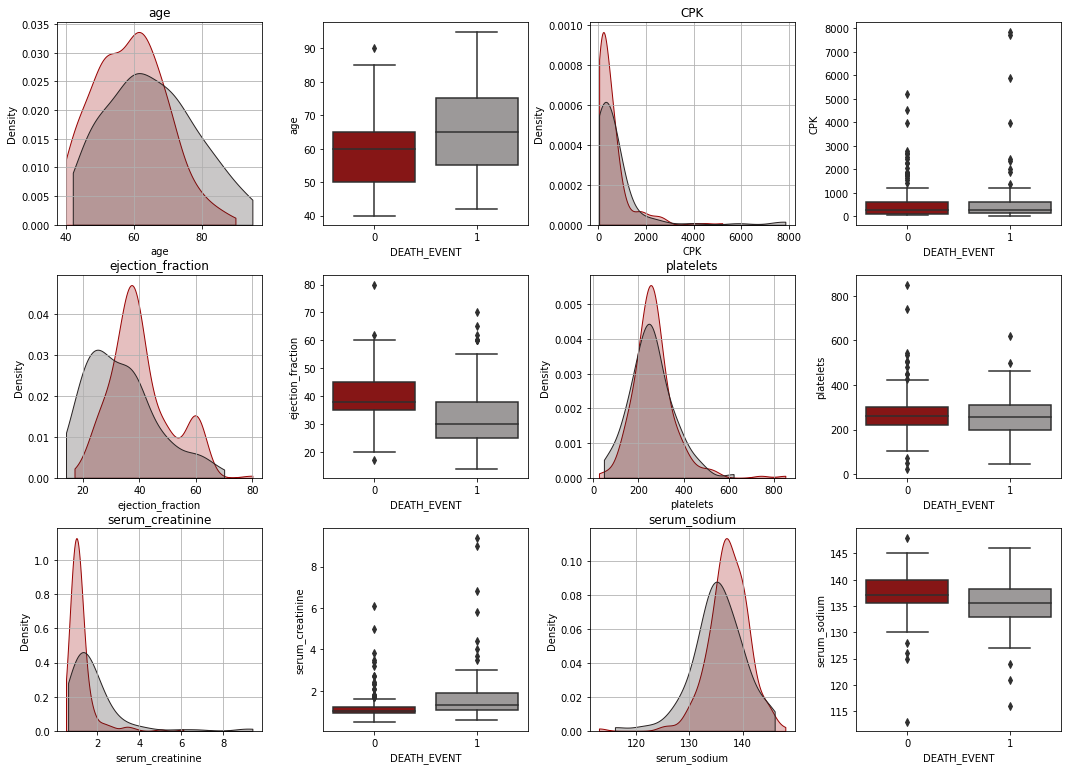

In [99]:
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(hf.loc[hf["DEATH_EVENT"]==0, col], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
    sns.kdeplot(hf.loc[hf["DEATH_EVENT"]==1, col], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
    plt.subplot(6, 4, i*2+2) 
    sns.boxplot(y = col, data = hf, x="DEATH_EVENT", palette = ["#990303", "#9C9999"])   

As we can see already from the unnormalized distribution plot of the features, the most informative ones seem to be `ejection_fraction` and `serum_creatinine`.<br>
This is confirmed by the fact that in the original paper by Chicco and Jurman [[1](#references)] the analisys has been conducted taking into account only these two features.

Here are reported the **categorical** features

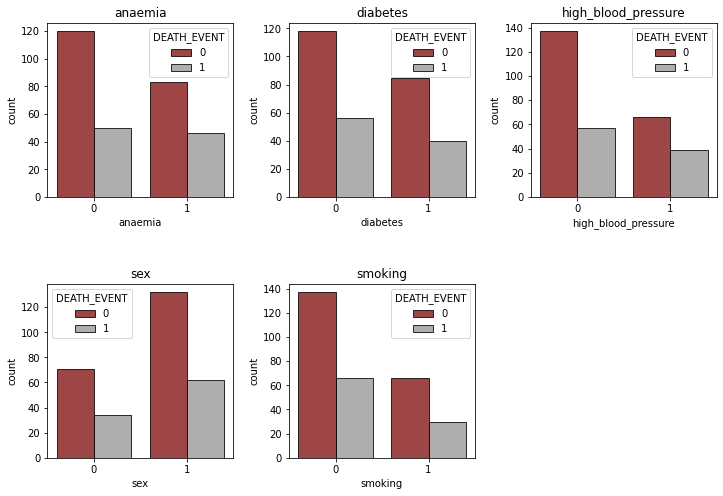

In [100]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=hf, x=col, hue="DEATH_EVENT", palette = ["#990303", "#9C9999"], alpha=0.8, edgecolor="k", linewidth=1)

<a id='Standardization'></a>
## Standardization <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>
One important step is standardization for numerical features that is performed via the standard `sklearn` function, removing the mean and scaling to unit variance.

\begin{align}
{z = \frac{(x−\bar{x})}{\hat{\sigma}}}
\end{align}

where $\bar{x}$ is the mean of the training samples and ${\hat{\sigma}}$ is the sample standard deviation.

In [101]:
from sklearn.preprocessing import StandardScaler

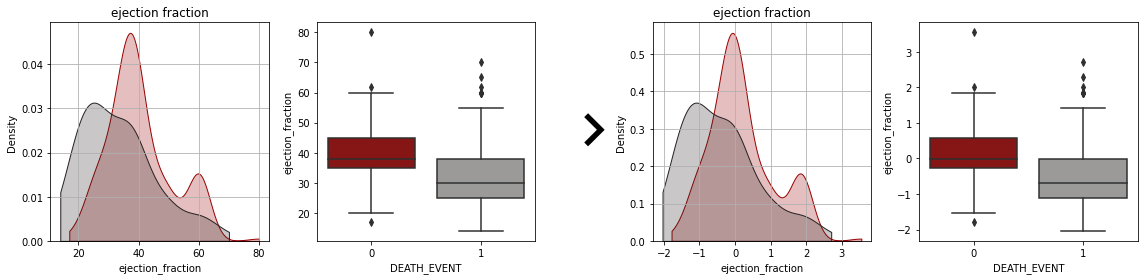

In [102]:
import matplotlib.image as mpimg
from matplotlib import gridspec

hf_norm = hf.copy()

for i, col in enumerate(numerical_features):
    hf_norm[[col]] = StandardScaler(with_mean=True, with_std=True).fit_transform(hf_norm[[col]])
    
plt.figure(figsize=(16, 4))
gs  = gridspec.GridSpec(1, 5, width_ratios=[1, 1 ,0.1, 1, 1])
plt.subplot(gs[0])   
plt.grid(True)
plt.title("ejection fraction")
sns.kdeplot(hf.loc[hf["DEATH_EVENT"]==0, "ejection_fraction"], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
sns.kdeplot(hf.loc[hf["DEATH_EVENT"]==1, "ejection_fraction"], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
plt.subplot(gs[1]) 
sns.boxplot(y = "ejection_fraction", data = hf, x="DEATH_EVENT", palette = ["#990303", "#9C9999"])  
plt.subplot(gs[2])
plt.imshow(mpimg.imread("img/right_arrow.png"))
plt.axis('off')
plt.subplot(gs[3])
plt.grid(True)
plt.title("ejection fraction")
sns.kdeplot(hf_norm.loc[hf["DEATH_EVENT"]==0, "ejection_fraction"], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
sns.kdeplot(hf_norm.loc[hf["DEATH_EVENT"]==1, "ejection_fraction"], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
plt.subplot(gs[4])
sns.boxplot(y = "ejection_fraction", data = hf_norm, x="DEATH_EVENT", palette = ["#990303", "#9C9999"]);  
plt.tight_layout()

<a id='Correlation_matrix'></a>
## Correlation matrix <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

To see how features are correlated is useful to look at the correlation matrix that is a matrix in which are showed the correlation values of each couple of features according to the **Pearson's correlation coefficient**:

${\displaystyle \rho _{X_1,X_2}={\frac {\operatorname {cov} (X_1,X_2)}{\sigma _{X_1}\sigma _{X_2}}}}$ 

Where $cov$ stands for the covariance measure:

${\displaystyle \operatorname {cov} (X_1,X_2)=\operatorname {E}{{\big [}(X_1-\operatorname {E} [X_1])(X_2-\operatorname {E} [X_2]){\big ]}},}$

That is computed for every pair of features ${X_1}$ and ${X_2}$

#### Results
From the results we can say that `smoking`, `high_blood_pressure`, `diabetes` and `platelets` can be easily dropped.<br>
Altough `sex`and `anaemia` produce still very low values of the statistic, they are kept.
(In this way we can see how models handle a mix of continouos and binary features)

In [103]:
kfold_train_df, kfold_val_df = ho_train_df.copy(), ho_val_df.copy()

all_features = ['anaemia', 'sex', 'age', 'CPK',
                'ejection_fraction', 'serum_creatinine', 'serum_sodium']

#ho_train_df, ho_val_df = ho_train_df[all_features+["DEATH_EVENT"]], ho_val_df[all_features+["DEATH_EVENT"]]
#unnorm_ho_train_df, unnorm_ho_val_df = unnorm_ho_train_df[all_features+["DEATH_EVENT"]], unnorm_ho_val_df[all_features+["DEATH_EVENT"]]

<a id='KFold_case'></a>
### KFold case

When kfold crossvalidation is done, feature selection needs to be performed inside every iteration, in fact, performing it before would mean considering the whole training set and this can lead to an overestimation of the accuracy during cross validation.<br>
In this case, feature selection consists in dropping features that have a very low mutual information and chi squared statistic so it's possible to evaluate those for each iteration of KFold.

Mutual information with respect to DEATH_EVENT (5 folds)


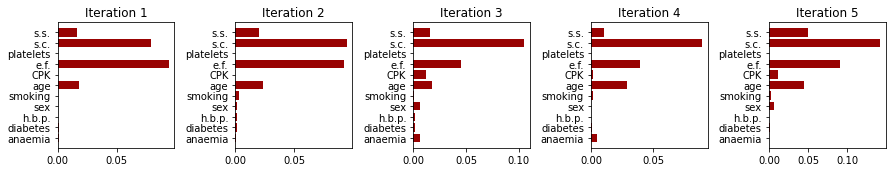

In [104]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(12.5, 2.5))

print("Mutual information with respect to DEATH_EVENT (5 folds)")
for i, (train_idx, val_idx) in enumerate(kf.split(kfold_train_df, kfold_train_df["DEATH_EVENT"])):
    MI=(mutual_info_classif(kfold_train_df.iloc[train_idx][categorical_features+numerical_features],
                             kfold_train_df.iloc[train_idx]["DEATH_EVENT"], n_neighbors=20,
                             discrete_features=[True, True, True, True, True, False, False, False, False, False, False],
                             random_state=42))
    plt.subplot(1, 5, i+1)
    plt.title(f"Iteration {i+1}")
    plt.barh(y=['anaemia', 'diabetes', 'h.b.p.','sex', 'smoking', 'age', 'CPK', 'e.f.', 'platelets',
         's.c.', 's.s.'], width=MI, color="#990303", label="test statistic")
    
plt.tight_layout()  

Chi squared test statistics (5 folds)


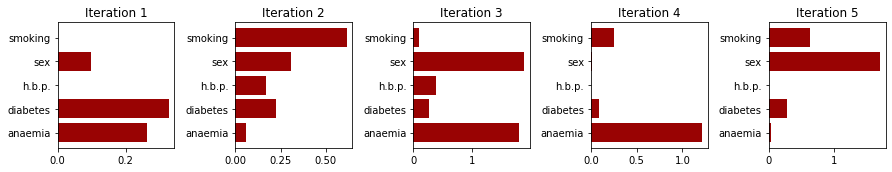

In [105]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plt.figure(figsize=(12.5, 2.5))
print("Chi squared test statistics (5 folds)")
for i, (train_idx, val_idx) in enumerate(kf.split(kfold_train_df, kfold_train_df["DEATH_EVENT"])):
    stats = []
    p_values = []

    for feat in categorical_features:

        stat, p = chi2_test(kfold_train_df.iloc[train_idx], feat, "DEATH_EVENT")
        stats.append(stat)
        p_values.append(p)
    
    plt.subplot(1, 5, i+1)
    plt.title(f"Iteration {i+1}")
    plt.barh(y=['anaemia', 'diabetes', 'h.b.p.', 'sex', 'smoking'], width=stats, color="#990303", label="test statistic")
plt.tight_layout()

We can see that for the mutual information, the vast majority of the cases the features are kept or dropped analogously to the holdout feature election so we stick with the original feature selection removing `platelets`. <br>

For the chi-squared test the results are quite different, so it's decided to keep the top 2 for each iteration.

|Iteration|Feature 1| Feature 2|
|:---:|---|---|
|**Iteration 1**|anaemia|diabetes|
|**Iteration 2**|sex|smoking|
|**Iteration 3**|anaemia|sex|
|**Iteration 4**|anaemia|smoking|
|**Iteration 5**|sex|smoking|

In [106]:
numerical_features = ['age', 'CPK', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']
all_features_kfold = [
    ["anaemia", "diabetes"]+numerical_features,
    ["sex", "smoking"]+numerical_features,
    ["anaemia", "sex"]+numerical_features,
    ["anaemia", "smoking"]+numerical_features,
    ["sex", "smoking"]+numerical_features,
]

<a id='Class_imbalance'></a>
## Class imbalance <a style="text-decoration:none" href="#Exploratory_data_analisys">⤴</a>

One thing to take into account is the possible class imbalance.<br>

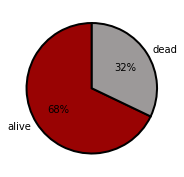

In [107]:
plt.figure(figsize=(3, 3))
plt.pie(hf["DEATH_EVENT"].value_counts(),
        labels = ["alive", "dead"],
        colors = ["#990303", "#9C9999"], 
        wedgeprops={'edgecolor':'black', 'linewidth': 2}, 
        autopct = lambda y: str(round(y))+"%",
        startangle=90);

As we can see, even if not so strong, there is a class imbalance.<br>
This can leads to biased results that can be noticed by measures such as `recall`, `precision` or `f1`.<br>
To handle class inbalance it's possible to *re-balance* the dataset with different techniques.

<a id='oversampling'></a>
### Random oversampling

Random oversampling is a resample technique that consists in taking the under-represented class samples and sampling new samples from them until the classes are balanced.<br>
During training, random oversampling needs to be done after the subdivision into train, validation and test to avoid **data leakage**.<br>
The idea is that, not being able to sample more samples from the true distribution, we sample them from the empirical distribution coming from the samples that we already have.

In [108]:
n_to_sample = len(ho_train_df[ho_train_df.DEATH_EVENT==0]) - len(ho_train_df[ho_train_df.DEATH_EVENT==1])
new_samples = ho_train_df[ho_train_df.DEATH_EVENT==1].sample(n_to_sample, replace=True, random_state=42)

ho_train_df_rs = ho_train_df.append(new_samples)

new_samples = unnorm_ho_train_df[unnorm_ho_train_df.DEATH_EVENT==1].sample(n_to_sample, replace=True, random_state=42)
unnorm_ho_train_df_rs = unnorm_ho_train_df.append(new_samples)

C:\Users\nites\AppData\Local\Temp\ipykernel_2288\2070853731.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ho_train_df_rs = ho_train_df.append(new_samples)
C:\Users\nites\AppData\Local\Temp\ipykernel_2288\2070853731.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unnorm_ho_train_df_rs = unnorm_ho_train_df.append(new_samples)


Here we can see the distribution of `ejection_fraction` for only under-represented class samples before and after oversampling. (the line is a kde)

d:\programs\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\programs\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


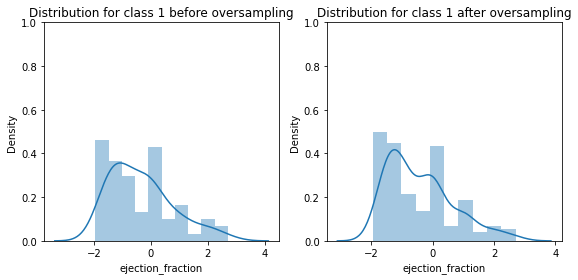

In [109]:
nbins = 10
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
plt.ylim(0, 1)
plt.title("Distribution for class 1 before oversampling")
sns.distplot(ho_train_df[ho_train_df.DEATH_EVENT==1].ejection_fraction, bins=nbins)
plt.subplot(1, 2, 2)
plt.ylim(0, 1)
plt.title("Distribution for class 1 after oversampling")
sns.distplot(ho_train_df_rs[ho_train_df_rs.DEATH_EVENT==1].ejection_fraction, bins=nbins);
plt.tight_layout()

<a id='Results_and_conclusions'></a>
# Results and conclusions <a style="text-decoration:none" href="#index">⤴</a>

Here we can see the results obtained with different models and different rebalancing techniques for the **Hearth Disease** dataset.<br>
Both **accuracy** and **f1 score** (inside parenthesis) are showed.

| Model  | Holdout Original | Holdout Oversampling | Holdout SMOTE | Holdout class-weight=balanced | KFold Original | KFold Oversampling | KFold SMOTE | KFold class-weight=balanced| 
| :------------- | :-------------: | :-------------: | :-------------: | :-------------: | :-------------: | :-------------: | :-------------: | :-------------: |
| **Decision Tree** | 0.706 (0.607) | 0.733 (0.655) | 0.706 (0.645) | 0.747 (0.698) | 0.790 (0.560) | 0.794 (0.687) | 0.754 (0.598) | 0.785 (0.664) | 
| **Random Forest** | 0.707 (0.577) | **0.787 (0.733)** | 0.747 (0.667) | 0.733 (0.642) | 0.803 (0.625) | **0.808 (0.683)** | 0.794 (0.654) | 0.799 (0.617) | 
| **Linear Regression** | 0.667 (0.444) | 0.693 (0.635) | 0.707 (0.633) | - | 0.776 (0.508) | 0.727 (0.611) | 0.750 (0.614) | - | 
| **Logistic Regression** | 0.667 (0.444) | 0.707 (0.645) | 0.733 (0.667) | 0.707 (0.645) | 0.772 (0.501) | 0.736 (0.607) | 0.759 (0.630) | 0.740 (0.619) | 
| **Linear SVM** | 0.653 (0.458) | 0.720 (0.667) | 0.720 (0.644) | 0.706 (0.656) | 0.736 (0.594) | 0.759 (0.606) | 0.781 (0.519) | 0.718 (0.574) | 
| **Poly SVM** | 0.680 (0.538) | 0.693 (0.582) | 0.640 (0.542) | 0.706 (0.607) | 0.759 (0.503) | 0.759 (0.562) | 0.763 (0.589) | 0.754 (0.536) | 
| **RBF SVM** | 0.680 (0.571) | 0.680 (0.657) | 0.720 (0.657) | 0.747 (0.698) | 0.790 (0.542) | 0.781 (0.669) | 0.794 (0.680) | **0.799 (0.693)** | 
| **KNN original** | 0.640 (0.501) | 0.720 (0.644) | 0.680 (0.586) | - | 0.772 (0.471) | 0.737 (0.603) | 0.763 (0.604) | - | 
| **KNN distance** | 0.667 (0.510) | 0.733 (0.667) | 0.793 (0.610) | - | 0.776 (0.485) | 0.737 (0.599) | 0.759 (0.601) | - | 
| **Flexible Bayes** | 0.733 (0.730) | 0.733 (0.714) | 0.747 (0.716) | - | 0.799 (0.631) | 0.772 (0.616) | 0.785 (0.611) | - | 
| **Gaussian Naive Bayes** | 0.693 (0.667) | 0.707 (0.686) | 0.733 (0.688) | - | 0.781 (0.653) | 0.763 (0.619) | 0.727 (0.606) | - | 

We can clearly see how using some rebalancing techniques the **f1 score** increase substancially.<br>
In some cases SMOTE performs better with respect to random oversampling, and the opposite in others.<br>
Furthermore, where is possible to apply it, also the use of the `class-weight` parameter increases the performances, sometimes outperforming the other techniques.

Then we noticed how using Gaussian Naive Bayes, even without respecting the hypothesis, leads to good results and also with a Bayes Classifier with KDE, the results are in line.

Best overall model seems to be the **random forest** trained on the oversampled dataset, that delivers the best results in terms of accuracy and f1 score.<br>
Also **RBF-SVM** with `class-weights=balanced` provides some good results on KFold.

For the models that allow it, it's possible to evaluate the **ROC curve** to select a threshold according to the main goal (minimize false positives or maximize true positives) but the results in the table are obtained by fixing the threshold at 0.5.

The overall results seem in line with the ones obtained in the reference paper [[1]](#references) but it's needed to keep in mind that the metrics are highly influenced by the small dimension of the dataset (75 samples in holdout validation set).

<a id='references'></a>
# References  <a style="text-decoration:none" href="#index">⤴</a>

[[1]](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5)  D. Chicco, G. Jurman. "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone", 2020


[[2]](https://arxiv.org/abs/1106.1813) N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer. SMOTE: Synthetic Minority Over-sampling Technique, 2002


[[3]](https://dl.acm.org/doi/10.5555/2074158.2074196) G. H. John, P. Langley. Estimating Continuous Distributions in Bayesian  Classifiers, 1995

In [110]:
from IPython.core.display import HTML

# source https://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')